In [1]:
from brix import Indicator, Handler
import OpenCity
import geopandas as gpd
from shapely.geometry import Point, shape
import json
import requests
import urllib

In [2]:
table_name='providence_test'
geom_type='block_group'

model_radius=5000
reference_radius=2500

- Create the handler
- Get the geogrid
- Identify the state
- Get the state geometry
- find the overlap
- Assign the sim, model, reference zones
- Append the grid "zones" to the actual zones (if the zones properties are updated in one indicator, will they be updated for all?)

- all the above in a world object?

In [3]:
h=Handler(table_name)

In [4]:
# geogrid_data=h.get_geogrid_data(include_geometries=True)

In [5]:

# geogrid=geogrid_data.GEOGRID

In [6]:
# geogrid=h.get_GEOGRID()
# geom = [f['geometry'] for f in geogrid['features']]
# geogrid_gdp=gpd.GeoDataFrame({'geometry':geom})

In [7]:
get_url='https://cityio.media.mit.edu/api/table/'+table_name
with urllib.request.urlopen(get_url+'/GEOGRID') as url:
    geogrid=gpd.read_file(url.read().decode())

centroids=geogrid['geometry'].centroid
geogrid['x_centroid']=[c.x for c in centroids]
geogrid['y_centroid']=[c.y for c in centroids]
geogrid

<ipython-input-7-e3ea8eae3bb9>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=geogrid['geometry'].centroid


,id,interactive,name,geometry,x_centroid,y_centroid
0,0,Web,None,"POLYGON ((-71.42951 41.81539, -71.42951 41.814...",-71.429212,41.815170
1,1,Web,None,"POLYGON ((-71.42891 41.81539, -71.42891 41.814...",-71.428610,41.815170
2,2,Web,None,"POLYGON ((-71.42831 41.81539, -71.42831 41.814...",-71.428009,41.815170
3,3,Web,None,"POLYGON ((-71.42771 41.81539, -71.42771 41.814...",-71.427407,41.815170
4,4,Web,None,"POLYGON ((-71.42711 41.81539, -71.42711 41.814...",-71.426805,41.815170
...,...,...,...,...,...,...
395,395,Web,None,"POLYGON ((-71.42049 41.80684, -71.42049 41.806...",-71.420187,41.806616
396,396,Web,None,"POLYGON ((-71.41989 41.80684, -71.41989 41.806...",-71.419585,41.806616
397,397,Web,None,"POLYGON ((-71.41928 41.80684, -71.41928 41.806...",-71.418984,41.806616
398,398,Web,None,"POLYGON ((-71.41868 41.80684, -71.41868 41.806...",-71.418382,41.806616


In [8]:
def init_geogrid(table_name, interactive_zone=None):
    """
    initialises the available types on the front-end to a default list from text file
    initialises the GEOGRIDDATA to all "None"
    """

    get_url='https://cityio.media.mit.edu/api/table/'+table_name
    post_url='https://cityio.media.mit.edu/api/table/update/'+table_name
    with urllib.request.urlopen(get_url+'/GEOGRID') as url:
        geogrid=json.loads(url.read().decode()) 
    default_types=json.load(open('data/default_types.json'))
    geogrid['properties']['types']=default_types

    if interactive_zone is not None:
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            geogrid_gpd=gpd.read_file(url.read().decode())
        geogrid_intersect_interactive=gpd.overlay(geogrid_gpd, interactive_zone)
        intersect_ids=geogrid_intersect_interactive['id'].values
    else:
        intersect_ids=list(range(len(geogrid['features'])))

    for i in range(len(geogrid['features'])):
        geogrid['features'][i]['properties']['name']='None'
        geogrid['features'][i]['properties']['height']=[0]
        if i in intersect_ids:
            geogrid['features'][i]['properties']['interactive']='Web'
            geogrid['features'][i]['properties']['color']=[150,150,150,150]
        else:
            geogrid['features'][i]['properties']['interactive']=False
            geogrid['features'][i]['properties']['color']=[0,0,0,0]
            
    r = requests.post(post_url+'/GEOGRID', data = json.dumps(geogrid))
    print('Initialise GEOGRID: {}'.format(r))
    return geogrid['properties']
    
def identify_state(properties):
    # TODO: if table already existed, just load state from text file
    print('Downloading state outlines')
    state_outlines=gpd.read_file(
        'https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip')
    state_outlines=state_outlines.to_crs("EPSG:4326")
    table_lon, table_lat=properties['header']['longitude'], properties['header']['latitude']
    table_Point=Point(table_lon, table_lat)
    for ind, row in state_outlines.iterrows():
        if row['geometry'].contains(table_Point):
            return row['GEOID']
    return None

def assign_sim_area(geogrid, zones):
    """
    find the baseline zones which overlap with the geogrid
    these are the simulation area
    """
    zones['copy_GEOID']=zones.index.copy()
    grid_intersect_zones=gpd.overlay(geogrid, zones, 'intersection')
    zones['sim_area']=zones.index.isin(grid_intersect_zones['copy_GEOID'].unique())
    return zones


def init_geogrid(table_name, interactive_zone=None):
    """
    initialises the available types on the front-end to a default list from text file
    initialises the GEOGRIDDATA to all "None"
    """

    get_url='https://cityio.media.mit.edu/api/table/'+table_name
    post_url='https://cityio.media.mit.edu/api/table/update/'+table_name
    with urllib.request.urlopen(get_url+'/GEOGRID') as url:
        geogrid=json.loads(url.read().decode()) 
    default_types=json.load(open('data/default_types.json'))
    geogrid['properties']['types']=default_types

    if interactive_zone is not None:
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            geogrid_gpd=gpd.read_file(url.read().decode())
        geogrid_intersect_interactive=gpd.overlay(geogrid_gpd, interactive_zone)
        intersect_ids=geogrid_intersect_interactive['id'].values
    else:
        intersect_ids=list(range(len(geogrid['features'])))

    for i in range(len(geogrid['features'])):
        geogrid['features'][i]['properties']['name']='None'
        geogrid['features'][i]['properties']['height']=[0]
        if i in intersect_ids:
            geogrid['features'][i]['properties']['interactive']='Web'
            geogrid['features'][i]['properties']['color']=[50,50,50,50]
        else:
            geogrid['features'][i]['properties']['interactive']=False
            geogrid['features'][i]['properties']['color']=[0,0,0,0]
            
    r = requests.post(post_url+'/GEOGRID', data = json.dumps(geogrid))
    print('Initialise GEOGRID: {}'.format(r))
    return geogrid['properties']

In [9]:
try:
    interactive_zone=gpd.read_file('./tables/{}/interactive.geojson'.format(table_name))
    print('using interactive zone')
except:
    interactive_zone=None
properties=init_geogrid(table_name, interactive_zone=interactive_zone)

Initialise GEOGRID: <Response [200]>


In [10]:
state_fips=identify_state(properties)

Getting geometry (block_group) for state: Rhode Island


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data
Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data


<AxesSubplot:>

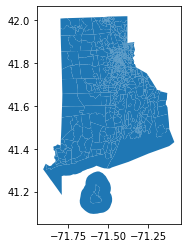

In [11]:
st=OpenCity.US_State(state_fips, year=2018, geom_type=geom_type)
st.get_geometry()
# st.remove_non_urban_zones()
st.get_lodes_data( include=['wac', 'rac', 'od'])
st.add_lodes_cols_to_shape()
st.geom.plot()

In [12]:
st.subset_geom_by_distance(centre_x_y=[geogrid.x_centroid.mean(), geogrid.y_centroid.mean()], 
                                   radius=reference_radius, name='reference_area')

st.subset_geom_by_distance(centre_x_y=[geogrid.x_centroid.mean(), geogrid.y_centroid.mean()], 
                                   radius=model_radius, name='model_area')

st.geom=assign_sim_area(gpd.GeoDataFrame(geogrid), st.geom)

	 Subsetting zones by distance
	 Subsetting zones by distance


In [13]:
zones=st.geom.rename(columns={col: 'area' for col in st.geom.columns if 'ALAND' in col})

In [14]:
zones.loc[zones['model_area']].to_file('tables/{}/zones.geojson'.format(table_name), driver='GeoJSON')

In [15]:
simpop_df=st.lodes_to_pop_table(
    model_subset_name='model_area', sim_subset_name='sim_area')
simpop_df.to_csv('tables/{}/simpop_df.csv'.format(table_name), index=False)

Using 1715 of 154176 rows in OD data
0 of 1715


In [16]:
geogrid.to_file('tables/{}/geogrid.geojson'.format(table_name), driver='GeoJSON')